# **Adding more fields**

In [1]:
%matplotlib inline
import numpy as np
import xarray as xr
import os
from matplotlib import pyplot as plt, animation, rc
import matplotlib.colors as mcolors
from datetime import datetime, timedelta
from dateutil.parser import parse
from scipy.io import loadmat
from cartopy import crs, feature

from parcels import FieldSet, Field, VectorField, ParticleSet, JITParticle, ErrorCode, AdvectionRK4, AdvectionRK4_3D

rc('animation', html='html5')

## Functions

#### Path prefix

In [2]:
def make_prefix(date, path, res='h'):
    """Construct path prefix for local SalishSeaCast results given date object and paths dict
    e.g., /results2/SalishSea/nowcast-green.201905/daymonthyear/SalishSea_1h_yyyymmdd_yyyymmdd
    """

    datestr = '_'.join(np.repeat(date.strftime('%Y%m%d'), 2))
    folder = date.strftime("%d%b%y").lower()
    prefix = os.path.join(path, f'{folder}/SalishSea_1{res}_{datestr}')
    
    return prefix

#### Scatter_Colors

In [3]:
colors=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']
def scatter_particles(ax, N,colors, nmin, nmax,yvar):
    scatter=[]
    #N is the number of stations
    #Color is a list of strings picking the desired colors
    #nmin is t0, nmax is tmax
    #yvar is the y coordinate
    
    starts = np.arange(0,N*n,n)
    ends = np.arange(n-1,N*n,n)
    if N < len(colors):
        colors = colors[0:N]
    elif N > len(colors):
        con = 0
        while N > len(colors):
            colors.append(colors[con])
            con+=1
    if nmin==nmax:
        for i in range(N):
            scatter.append(ax.scatter(ds.lon[starts[i]:ends[i], nmin], yvar[starts[i]:ends[i], nmin],c=colors[i],s=5))
    else:
        for i in range(N):
            scatter.append(ax.scatter(ds.lon[starts[i]:ends[i], nmin:nmax], yvar[starts[i]:ends[i], nmin:nmax],c=colors[i],s=5))
    return scatter

#### Define particle type

In [4]:
# from parcels import Variable

# class WParticle(JITParticle):            
#                                                             #Variable 'w' with initial value 0.
#     z0 = Variable('Z0', initial=0) 

#### Useful Kernel

In [5]:
def DeleteParticle(particle, fieldset, time):
    """Delete particle from OceanParcels simulation to avoid run failure
    """
    
    print(f'Particle {particle.id} lost !! [{particle.lon}, {particle.lat}, {particle.depth}, {particle.time}]')
    particle.delete()

In [10]:
def Buoyancy(particle, fieldset, time):
    '''Stokes law settling velocity and critical sinking velocity'''
    Rp = 960 #Density particle (PE)
    ESD=5e-5 #Size particle (ESD) equivalent spherical diameter
    #visc=1e-3 #average viscosity sea water
     
    z = particle.depth
    u = fieldset.U[time, particle.depth, particle.lat, particle.lon]
    if  u == 0:
        dz = 0
    else:
        
        a = -0.15
        b = 0.78
        k=4.5e-3
        pa=10.13
        ro0 = 1027
        t0 = 10
        s0 = 35
        g = 9.8
        t = fieldset.T[time, particle.depth, particle.lat, particle.lon]
        s = fieldset.S[time, particle.depth, particle.lat, particle.lon]
        p = ((g*z*ro0)/1e4)+pa
        ro = ro0 + a*(t-t0) + b*(s-s0) + k*p
        visc = 4.2844e-5 + 1/(0.157*((t + 64.993)**2)-91.296)
        Ws= ((ESD**2)*g*(Rp-ro))/(18*visc)
        WWS =(11.68 + 0.1991*ESD*1e6 + 0.0004*(ESD*1e6)**2- 0.0993*(Rp-ro) + 0.0002*(Rp-ro)**2)/86400
        
    if Ws>WWS:
        dz = WWS*particle.dt
    else:
        dz = Ws*particle.dt
    if dz+z > 0:
        particle.depth += dz
    else:
        particle.depth = 0.5

## Load drifters and definitions

In [11]:
# Define paths
paths = {
    'NEMO': '/results2/SalishSea/nowcast-green.201905/',
    'coords': '/ocean/jvalenti/MOAD/grid/coordinates_seagrid_SalishSea201702.nc',
    'mask': '/ocean/jvalenti/MOAD/grid/mesh_mask201702.nc',
    'out': '/home/jvalenti/MOAD/analysis-jose/notebooks/results',
    'anim': '/home/jvalenti/MOAD/animations'
}

In [12]:
# Duration and timestep [s]
length = 20
duration = timedelta(days=length)
dt = timedelta(minutes=2) #toggle between - or + to pick backwards or forwards maximum == 30

In [13]:
N = 6 # number of deploying locations
n = 100 # 1000   # number of particles per location
# Define Gaussian point cloud in the horizontal
r = 3000   # radius of particle cloud [m]
deg2m = 111000 * np.cos(50 * np.pi / 180)
var = (r / (deg2m * 3))**2
x_offset, y_offset = np.random.multivariate_normal([0, 0], [[var, 0], [0, var]], [n,N]).T
# Set a uniform distribution in depth, from dmin to dmax
dmin = 0.
dmax = 5.
zvals = dmin + np.random.random_sample([n,N]).T*(dmax-dmin)

## Simulation

In [14]:
start = datetime(2018, 1, 17)
daterange = [start+timedelta(days=i) for i in range(length)]
# Build filenames
Ulist, Vlist, Wlist = [], [], []
Tlist= []
for day in range(duration.days):
    path_NEMO = make_prefix(start + timedelta(days=day), paths['NEMO'])
    print (path_NEMO)
    Ulist.append(path_NEMO + '_grid_U.nc')
    Vlist.append(path_NEMO + '_grid_V.nc')
    Wlist.append(path_NEMO + '_grid_W.nc')
    Tlist.append(path_NEMO + '_grid_T.nc')

# Load NEMO forcing : note, depth aware but no vertical advection, particles stay at their original depth
filenames = {
    'U': {'lon': paths['coords'], 'lat': paths['coords'], 'depth': Wlist[0], 'data': Ulist},
    'V': {'lon': paths['coords'], 'lat': paths['coords'], 'depth': Wlist[0], 'data': Vlist},
    'W': {'lon': paths['coords'], 'lat': paths['coords'], 'depth': Wlist[0], 'data': Wlist},
    'T': {'lon': paths['coords'], 'lat': paths['coords'], 'depth': Wlist[0], 'data': Tlist},
    'S': {'lon': paths['coords'], 'lat': paths['coords'], 'depth': Wlist[0], 'data': Tlist},
}
variables = {'U': 'vozocrtx', 'V': 'vomecrty','W': 'vovecrtz','T':'votemper','S':'vosaline'}
dimensions = {'lon': 'glamf', 'lat': 'gphif', 'depth': 'depthw','time': 'time_counter'}

#bring salish sea results into field_set
field_set = FieldSet.from_nemo(filenames, variables, dimensions, allow_time_extrapolation=True)

         It will be opened with no decoding. Filling values might be wrongly parsed.


/results2/SalishSea/nowcast-green.201905/17jan18/SalishSea_1h_20180117_20180117
/results2/SalishSea/nowcast-green.201905/18jan18/SalishSea_1h_20180118_20180118
/results2/SalishSea/nowcast-green.201905/19jan18/SalishSea_1h_20180119_20180119
/results2/SalishSea/nowcast-green.201905/20jan18/SalishSea_1h_20180120_20180120
/results2/SalishSea/nowcast-green.201905/21jan18/SalishSea_1h_20180121_20180121
/results2/SalishSea/nowcast-green.201905/22jan18/SalishSea_1h_20180122_20180122
/results2/SalishSea/nowcast-green.201905/23jan18/SalishSea_1h_20180123_20180123
/results2/SalishSea/nowcast-green.201905/24jan18/SalishSea_1h_20180124_20180124
/results2/SalishSea/nowcast-green.201905/25jan18/SalishSea_1h_20180125_20180125
/results2/SalishSea/nowcast-green.201905/26jan18/SalishSea_1h_20180126_20180126
/results2/SalishSea/nowcast-green.201905/27jan18/SalishSea_1h_20180127_20180127
/results2/SalishSea/nowcast-green.201905/28jan18/SalishSea_1h_20180128_20180128
/results2/SalishSea/nowcast-green.201905

### Change name for each run!!

In [15]:
# Set output file name.  Maybe change for each run
fn = f'LongPE-MP' + '_'.join(d.strftime('%Y%m%d')+'_1n' for d in [start, start+duration]) + '.nc'
outfile = os.path.join(paths['out'], fn)
print(outfile)

/home/jvalenti/MOAD/analysis-jose/notebooks/results/LongPE-MP20180117_1n_20180206_1n.nc


### Set particle location

In [16]:
lon = np.zeros([N,n])
lat = np.zeros([N,n])
# Execute run
clon, clat = [-123.901172,-125.155849,-123.207648,-122.427508,-123.399769,-123.277731], [49.186308,49.975326,49.305448,47.622403,48.399420,49.11602]  # choose horizontal centre of the particle cloud
for i in range(N):
    lon[i,:]=(clon[i] + x_offset[i,:])
    lat[i,:]=(clat[i] + y_offset[i,:])
z = zvals

In [17]:
pset = ParticleSet.from_list(field_set, JITParticle, lon=lon, lat=lat, depth=z, time=start+timedelta(hours=2))

p_flt = pset.Kernel(Buoyancy) 

pset.execute(AdvectionRK4_3D + p_flt, 
             runtime=duration, 
             dt=dt,
             output_file=pset.ParticleFile(name=outfile, outputdt=timedelta(hours=1)),
             recovery={ErrorCode.ErrorOutOfBounds: DeleteParticle})

INFO: Compiled ArrayJITParticleAdvectionRK4_3DBuoyancy ==> /tmp/parcels-2894/lib01838bb0254f39f50a463c79dd44a6fd_0.so
INFO: Temporary output files are stored in /home/jvalenti/MOAD/analysis-jose/notebooks/results/out-ESMBWJSV.
INFO: You can use "parcels_convert_npydir_to_netcdf /home/jvalenti/MOAD/analysis-jose/notebooks/results/out-ESMBWJSV" to convert these to a NetCDF file during the run.
 23% (408600.0 of 1728000.0) |##         | Elapsed Time: 0:04:30 ETA:   0:27:18

Particle 90 lost !! [-124.73973705644438, 49.81147122458796, 1.8504309401033356e-06, 414120.0]


 39% (675000.0 of 1728000.0) |####       | Elapsed Time: 0:07:36 ETA:   0:21:43

Particle 404 lost !! [-124.77809283099445, 48.496967887270635, 44.15567947881172, 681480.0]


 53% (932400.0 of 1728000.0) |#####      | Elapsed Time: 0:10:34 ETA:   0:09:05

Particle 494 lost !! [-124.83830785607496, 48.56869593082169, 33.2616023107566, 938760.0]


 54% (946800.0 of 1728000.0) |######     | Elapsed Time: 0:10:44 ETA:   0:08:50

Particle 441 lost !! [-124.76141247820352, 48.477079639805645, 22.92737594405506, 952320.0]


 57% (1000800.0 of 1728000.0) |#####     | Elapsed Time: 0:11:22 ETA:   0:08:16

Particle 469 lost !! [-124.81136935154932, 48.536624963283884, 5.290419855930176, 1007760.0]


 58% (1008000.0 of 1728000.0) |#####     | Elapsed Time: 0:11:27 ETA:   0:08:14

Particle 320 lost !! [-122.55557229531763, 48.213855950402106, 8.782392030629027e-09, 1014000.0]


 59% (1027800.0 of 1728000.0) |#####     | Elapsed Time: 0:11:42 ETA:   0:15:15

Particle 437 lost !! [-124.8750313863951, 48.61239373881685, 5.142891401600411, 1033440.0]


 59% (1029600.0 of 1728000.0) |#####     | Elapsed Time: 0:11:43 ETA:   0:09:20

Particle 417 lost !! [-124.85155243789092, 48.584457956191855, 0.1772610353655498, 1035360.0]


 65% (1125000.0 of 1728000.0) |######    | Elapsed Time: 0:12:51 ETA:   0:12:13

Particle 460 lost !! [-124.87509258997035, 48.61246654842329, 4.793520266050883, 1130400.0]


 65% (1128600.0 of 1728000.0) |######    | Elapsed Time: 0:12:53 ETA:   0:12:18

Particle 465 lost !! [-124.74807952264126, 48.46118931747332, 0.170405224640563, 1134960.0]


 65% (1130400.0 of 1728000.0) |######    | Elapsed Time: 0:12:54 ETA:   0:07:36

Particle 489 lost !! [-124.7347165158886, 48.445246829675, 0.04352432169287482, 1136520.0]


 65% (1137600.0 of 1728000.0) |######    | Elapsed Time: 0:12:59 ETA:   0:06:50

Particle 499 lost !! [-124.75617292983964, 48.47083507680977, 0.3306560014561696, 1144560.0]


 66% (1141200.0 of 1728000.0) |######    | Elapsed Time: 0:13:02 ETA:   0:07:30

Particle 405 lost !! [-124.73165715590955, 48.44158878477357, 0.16249170922346634, 1148040.0]


 70% (1209600.0 of 1728000.0) |#######   | Elapsed Time: 0:13:50 ETA:   0:06:00

Particle 473 lost !! [-124.80494314484388, 48.5289614424258, 44.39931235438365, 1216680.0]


 70% (1211400.0 of 1728000.0) |#######   | Elapsed Time: 0:13:52 ETA:   0:11:53

Particle 402 lost !! [-124.80486678501617, 48.52887056201642, 0.30729233981904897, 1217400.0]


 70% (1213200.0 of 1728000.0) |#######   | Elapsed Time: 0:13:53 ETA:   0:07:12

Correct cell not found for (-124.778329, 48.497249) after 1000000 iterations
Debug info: old particle indices: (yi, xi) 414 0
            new particle indices: (yi, xi) 415 43
            Mesh 2d shape:  898 398
            Relative particle position:  (xsi, eta) -4.4028019467058328e+01 1.0155607561984432e+00
Correct cell not found for (-124.838432, 48.568843) after 1000000 iterations
Debug info: old particle indices: (yi, xi) 432 0
            new particle indices: (yi, xi) 432 43
            Mesh 2d shape:  898 398
            Relative particle position:  (xsi, eta) -4.3980248037550943e+01 9.8829981338836104e-01
Correct cell not found for (-124.761601, 48.477305) after 1000000 iterations
Debug info: old particle indices: (yi, xi) 409 0
            new particle indices: (yi, xi) 409 43
            Mesh 2d shape:  898 398
            Relative particle position:  (xsi, eta) -4.3984204436003168e+01 9.7165526122576762e-01
Correct cell not found for (-124.811641, 48.536950) after 1000000 i

 71% (1229400.0 of 1728000.0) |#######   | Elapsed Time: 0:14:05 ETA:   0:10:12

Particle 431 lost !! [-124.74822642780121, 48.461364595516976, 232.10206796371256, 1235400.0]


 75% (1301400.0 of 1728000.0) |#######   | Elapsed Time: 0:14:55 ETA:   0:08:36

Particle 429 lost !! [-124.737910788839, 48.44905389490343, 5.261914353447299, 1308120.0]


 75% (1303200.0 of 1728000.0) |#######   | Elapsed Time: 0:14:56 ETA:   0:05:21

Particle 416 lost !! [-124.74465076499447, 48.457090277553355, 8.592473249824817, 1308720.0]


 75% (1308600.0 of 1728000.0) |#######   | Elapsed Time: 0:15:01 ETA:   0:08:30

Particle 490 lost !! [-124.71139655252578, 48.417408325880636, 62.86788351379221, 1314360.0]


 80% (1387800.0 of 1728000.0) |########  | Elapsed Time: 0:15:56 ETA:   0:06:56

Particle 410 lost !! [-124.87839897788898, 48.61639074056809, 35.27685800663446, 1393320.0]


 81% (1400400.0 of 1728000.0) |########  | Elapsed Time: 0:16:04 ETA:   0:03:48

Particle 428 lost !! [-124.90518480749849, 48.64824070533737, 21.099322831420448, 1406160.0]


 86% (1486800.0 of 1728000.0) |########  | Elapsed Time: 0:17:04 ETA:   0:02:45

Particle 470 lost !! [-124.79147306257978, 48.51291955904116, 49.6960445857758, 1492920.0]


 93% (1620000.0 of 1728000.0) |######### | Elapsed Time: 0:18:36 ETA:   0:01:10

Particle 453 lost !! [-124.80488582611154, 48.52889320636597, 42.013267236828796, 1626240.0]


 98% (1697400.0 of 1728000.0) |######### | Elapsed Time: 0:19:28 ETA:   0:00:36

Particle 366 lost !! [-124.78818464938004, 48.509000498319956, 40.931147729069004, 1703520.0]


 98% (1701000.0 of 1728000.0) |######### | Elapsed Time: 0:19:31 ETA:   0:00:31

Particle 434 lost !! [-124.77804902477907, 48.49691600583355, 27.939148341714745, 1706520.0]


 98% (1706400.0 of 1728000.0) |######### | Elapsed Time: 0:19:34 ETA:   0:00:14

Particle 497 lost !! [-124.90180101125597, 48.64421570683045, 10.137940774197155, 1712520.0]


100% (1728000.0 of 1728000.0) |##########| Elapsed Time: 0:19:42 Time:  0:19:42
/home/jvalenti/conda_envs/parcels/lib/python3.9/site-packages/numpy/lib/arraysetops.py:270: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ar = np.asanyarray(ar)


In [20]:
coords = xr.open_dataset(paths['coords'], decode_times=False)
mask = xr.open_dataset(paths['mask'])
ds = xr.open_dataset(outfile)

Text(0.5, 0, 'Longitude')

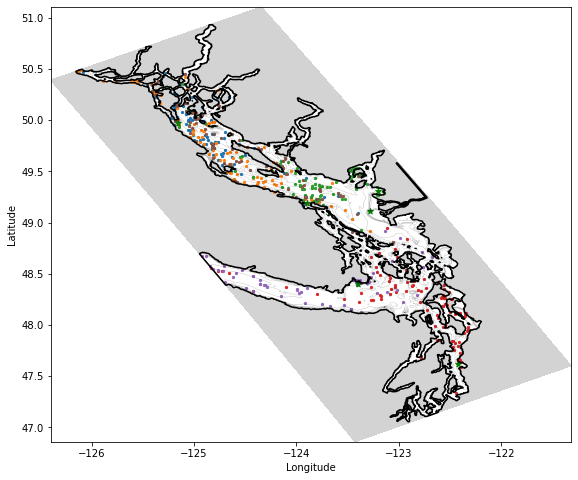

In [21]:
fig, ax = plt.subplots(figsize=(19, 8))
ax.contour(coords.nav_lon, coords.nav_lat, mask.mbathy[0,:,:],colors='k',linewidths=0.1)
ax.contourf(coords.nav_lon, coords.nav_lat, mask.tmask[0, 0, ...], levels=[-0.01, 0.01], colors='lightgray')
ax.contour(coords.nav_lon, coords.nav_lat, mask.tmask[0, 0, ...], levels=[-0.01, 0.01], colors='k')
ax.set_aspect(1/1)
nmin, nmax = 0, -1
scatter_particles(ax, N,colors, nmax, nmax, ds.lat)
ax.scatter(clon,clat,c='g', marker='*', linewidths=1)
plt.ylabel('Latitude')
plt.xlabel('Longitude')

Text(0.5, 0, 'Longitude')

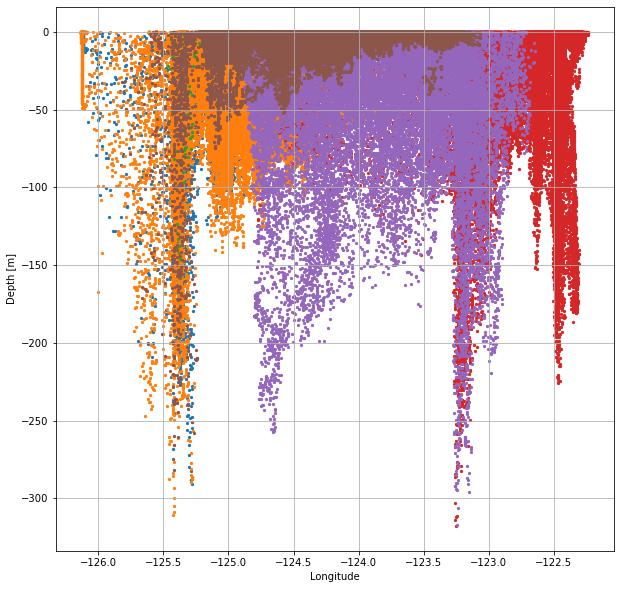

In [22]:
fig, ax = plt.subplots(figsize=(10, 10))
scatter_particles(ax, N,colors, nmin, nmax, -ds.z)
ax.grid()
plt.ylabel('Depth [m]')
plt.xlabel('Longitude')

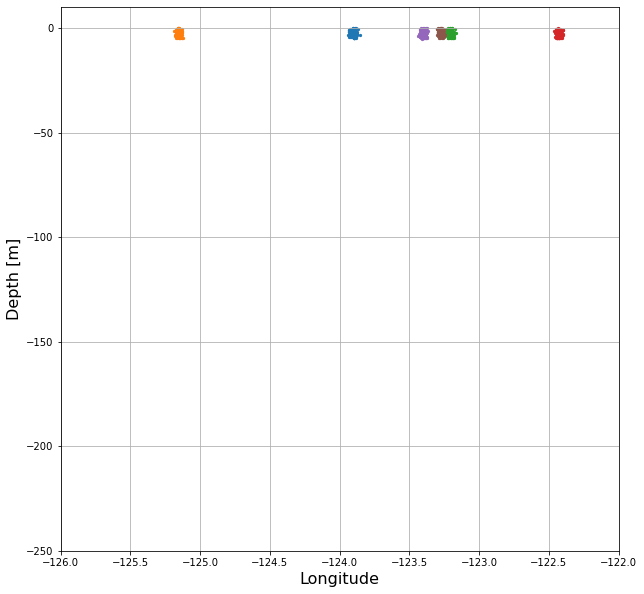

In [23]:
fps = 1
fig = plt.figure(figsize=(10, 10))
ax = plt.axes(xlim=(-126,-122),ylim=(-250,10))
ss = scatter_particles(ax, N,colors, 0, 0, -ds.z)
plt.ylabel('Depth [m]',fontsize=16)
plt.xlabel('Longitude',fontsize=16)
plt.grid()

def update(frames):
    global ss
    for scat in ss:
        scat.remove()
    ss = scatter_particles(ax, N,colors, frames, frames, -ds.z)
    return ss

anim = animation.FuncAnimation(fig, update, frames=np.arange(0,len(ds.lon[0,:]),fps),repeat=True)
anim
#f = paths["anim"]+"/depth_floating.mp4" 
#FFwriter = animation.FFMpegWriter()
#anim.save(f, writer = FFwriter)

In [ ]:
fps = 1
fig = plt.figure(figsize=(19, 8))
ax = plt.axes(xlim=(-127,-121),ylim=(46.8,51.2))
ax.contour(coords.nav_lon, coords.nav_lat, mask.mbathy[0,:,:],colors='k',linewidths=0.1)
ax.contourf(coords.nav_lon, coords.nav_lat, mask.tmask[0, 0, ...], levels=[-0.01, 0.01], colors='lightgray')
ax.contour(coords.nav_lon, coords.nav_lat, mask.tmask[0, 0, ...], levels=[-0.01, 0.01], colors='k')
ax.grid()
ax.set_aspect(1/1)
ax.scatter(clon,clat,c='g', marker='*', linewidths=2)
plt.ylabel('Latitude',fontsize=16)
plt.xlabel('Longitude',fontsize=16)
ss = scatter_particles(ax, N,colors, 0,0, ds.lat)

def update(frames):
    global ss
    for scat in ss:
        scat.remove()
    ss = scatter_particles(ax, N,colors, frames,frames, ds.lat)
    return ss


anim = animation.FuncAnimation(fig, update, frames=np.arange(0,len(ds.lon[0,:]),fps))
anim
#f=paths["anim"]+"/floating.mp4" 
#FFwriter = animation.FFMpegWriter()
#anim.save(f, writer = FFwriter)